# Transfer Learning and Training on (FASHION) MNIST

Now that we saw how to load and use a pretrained model for our aims, lets look at how to apply transfer learning in order to use a pretrained model as a feature extractor. Since the pretrained models available in torchvision are all trained on ImageNet, our model's last layer will provides 1000 output values, which are meant to be interpreted as log probabilities for the input to belong to every class, so we have to get rid of that layer and use a new layer with the needed number of parameters. The MNIST dataset contains digits from 0 to 9, so we need 10 output values, than we will replace the pretrained model's last layer to a new layer having 10 output features.

As usual, we will import all required packages, torch, numpy, etc

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
from torch.utils import data

import numpy as np

We should obviously also import the dataset and model classes from the torchvision package

In [1]:
from torchvision.datasets.mnist import FashionMNIST
from torchvision.models.resnet import resnet18
from torchvision import transforms, utils

from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

Instead of using the boring MNIST, we will use a better, less boring version of it, its called Fashion MNIST and consists of the same number of images, having the same dimensions and same calsses from 0 to 9 but representing dresses types instead of digits.

The images are W/B 28x28, having the pixel mean and std corresponding to 0.1307 and 0.3081, we can also use a data augmenting function from torchvision.transforms, which permit to "increase" the training dataset size by modifying the images applying transformations which won't change the image label, in this case we can use for example a random horizontal flipping function, which unsurprisingly applies horizontal flipping to images with probability p=0.5.

After creating the dataset objects we can finally pass them to the DataLoader init method to get our iterable dataloaders.

In [3]:
transfs_tr = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.1307], [0.3081])
])

transfs_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.1307], [0.3081])
])

dset_tr = FashionMNIST(root='../data/fmnist', train=True, download=True, transform=transfs_tr)
dset_val = FashionMNIST(root='../data/fmnist', train=False, download=True, transform=transfs_val)

dataloader_tr = data.DataLoader(dset_tr, batch_size=64)
dataloader_val = data.DataLoader(dset_val, batch_size=64)

we can actually show some of the images from the dataset using the torchvision's utils package, containing a couple of functions useful for visualization of tensor objects containing images.

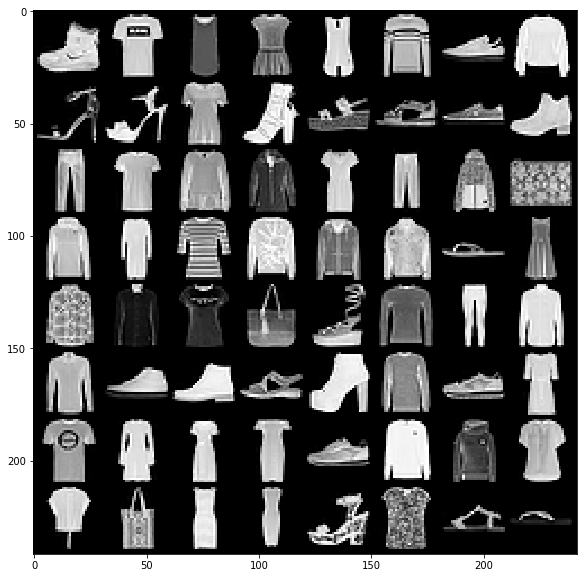

In [4]:
dset_temp = FashionMNIST(root='../data/fmnist', train=True, download=True, transform=transforms.ToTensor())
dataloader_temp = data.DataLoader(dset_temp, batch_size=64)
batch_img = next(iter(dataloader_temp))[0]

grid = utils.make_grid(batch_img)

plt.figure(figsize=(10,10))
plt.imshow(grid.numpy().transpose(1,2,0))

As you can see we really have a fashion dataset, certainly less boring than the "always the same" MNIST dataset

we can now get our model object, as seen in previous sections we will use a resnet model from the torchvision package, but given that we are on CPU and we still need to train a model, we will use a resnet18 (the smallest) instead of resnet152 (the largest). So we create the [pretrained] model and will apply some edits to it. 

For example, if I'm not wrong, the model is being deveoped to work with 224x224 images and it makes uses of a average pooling layer in order to average the features for each channel before enetring to the last, classifier layer. Since we have different size images, we can simply replace that layer with and AdaptiveAvgPool2d, a great pytorch module, which will compute the pooling window by itself in order to obtain the required output dimension. Since the standard resnet wants one value for each channel in the last but one layer (before the classifier), we will replace the resnet's avg pool with a nn.AdaptiveAvgPool2d((1,1)).

An other change we need to apply to our pretrained models is due to the fact that the model has been trained on RGB images, having thus 3 channels for image, but our images are W/B, so in attidion to adding a dimension for the color channel, we also need to adapt the first layer of the model. Since it contains 3channel filters, in order to make them work for our aims we simply need to perform a sum over the channel dimension for that parameters, and given that **sum(1)** will actually remove that dimension, we will readd it with the **unsqueeze** method.

Finally, as already explained above, we will replace the last (linear/affine/fully connected) layer having 1000 output features, with a much simpler layer having 10 output features. 

Last but not least, transfer learning requires that we don't update the already trained parameters, so we can put them in eval mode, we will also pass to our optimizer, not the entire model's parameters but only the parameters from our last fully connected layer.

In [6]:
model = resnet18(pretrained=True)
# replace the avgpool (it's a 7x7 pooling expecting Cx7x7 tensors so it would raise an error)
model.avgpool = nn.AdaptiveAvgPool2d((1,1))
# sum over input channels and read its dimension
model.conv1.weight.data = model.conv1.weight.data.sum(1).unsqueeze(1)
# replace the last layer (it has 1000 out features and we need new weights)
model.fc = nn.Linear(model.fc.in_features, 10)
model.eval()
model.fc.train()

Linear(in_features=512, out_features=10, bias=True)

Ok, our pretrained model is ready to give us features from the new data, lets define our loss function (Cross entropy as usual for classification problems) and our optimizer/ccriterion/optimization algorithm, SGD. We will use a learning rate of 0.1 and a momentum of 0.5

That's how you perform transfer learning, our problem now is that even if the model is less big respect othe models, our dataset contains a lot of samples, so we should wait to much time to train it on CPU, so we will train a much much simpler model from scratch to end this part of the tutorial, just remember that if you want to actually use the pretrained model and train only the last fully connected layer, you just need to pass **model.fc.parameters()** to the optimizer, instead of passing all model's parameters.

So we can now see also how to build a convolution network, which applies shifting filters of window size **k**, storing the filter output values for each shifting. For more information about the convolution layers you can firstly look at this awesome gif below, then go straight to the PyTorch documentation website.

<table style="width:100%; table-layout:fixed;">
  <tr>
    <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_no_strides.gif"></td>
    <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/arbitrary_padding_no_strides.gif"></td>
    <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/same_padding_no_strides.gif"></td>
    <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/full_padding_no_strides.gif"></td>
  </tr>
  <tr>
    <td>No padding, no strides</td>
    <td>Arbitrary padding, no strides</td>
    <td>Half padding, no strides</td>
    <td>Full padding, no strides</td>
  </tr>
  <tr>
    <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_strides.gif"></td>
    <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/padding_strides.gif"></td>
    <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/padding_strides_odd.gif"></td>
    <td></td>
  </tr>
  <tr>
    <td>No padding, strides</td>
    <td>Padding, strides</td>
    <td>Padding, strides (odd)</td>
    <td></td>
  </tr>
</table>


source: https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/no_padding_no_strides.gif

PyTorch convolutions documentation: http://pytorch.org/docs/stable/nn.html?highlight=convolution#convolution-layers

we can now define our loss function and optimizer objects

In [7]:
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.02, momentum=0.5)

We can now start our training, lets run the model for 10 epochs and see how it performs later

In [8]:
# how much batches the dataloader will iterate through??

len(dataloader_tr)

938

In [9]:
for epoch in range(1):
    for i, (x, y) in enumerate(dataloader_tr):
        l = loss(model(x), y)

        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        if i % 10 == 0:
            print('Epoch: {}, iter:{}, loss: {}'.format(epoch, i, l.item()))
        if i > 100:
            break

Epoch: 0, iter:0, loss: 2.445564031600952
Epoch: 0, iter:10, loss: 1.6330562829971313
Epoch: 0, iter:20, loss: 1.4073842763900757
Epoch: 0, iter:30, loss: 1.18770170211792
Epoch: 0, iter:40, loss: 1.0767278671264648
Epoch: 0, iter:50, loss: 1.1791547536849976
Epoch: 0, iter:60, loss: 1.018414855003357
Epoch: 0, iter:70, loss: 0.8039371967315674
Epoch: 0, iter:80, loss: 1.0639700889587402
Epoch: 0, iter:90, loss: 0.8216668367385864
Epoch: 0, iter:100, loss: 0.8977051377296448


Ok, finally we can evaluate our model accuracy performace on the validation dataset (not doing it on the training set because the model already saw those samples many times)

In [23]:
model.eval()
preds = torch.zeros(0, dtype=torch.long)
ys = torch.zeros(0, dtype=torch.long)
for i, (x, y) in enumerate(dataloader_val):
    preds = torch.cat((preds, model(x).max(1)[1]))
    ys = torch.cat((ys, y))
    if not i % 30:
        print(i)

correct = preds == ys
print('Accuracy: {}'.format(correct.to(torch.float).mean()))


0
30
60
90
120
150
Accuracy: 0.7228999733924866


And we can show the confusion matrix, which will show how many samples the model classifies correctly.

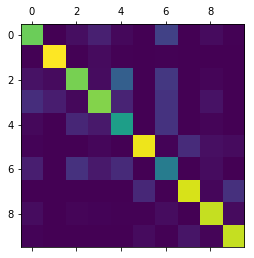

In [22]:
from sklearn.metrics import confusion_matrix

plt.matshow(confusion_matrix(preds.numpy(), ys.numpy()))
